In [28]:

# only run this once if required and margin list has changes from website!!! 
# just run everything else below this cell on regular basis

# import margin from westpac website
import tabula
import pandas as pd
myfile = 'https://www.westpac.com.au/content/dam/public/wbc/documents/pdf/pb/1999030/WOIL_Acceptable_Securities_List.pdf'

df2 = tabula.read_pdf(myfile,pages='all')
frames = [df2[0],df2[1],df2[2],df2[3]]
df2 = pd.concat(frames)
df2.drop(['Unnamed: 0','Unnamed: 1','APIR Code','Fund Name','APIR Code Fund Name'],axis=1) 
split1 = df2[['ASX Code','Security Name','LVR']]
split2 = df2[['ASX Code.1','Security Name.1','LVR.1']]
split2.columns=['ASX Code','Security Name','LVR']
df2 = pd.concat([split1,split2])
df2 = df2.dropna()
df2 = df2.drop_duplicates(subset=['ASX Code'])
#df2.loc[:,'ASX Code']=df2['ASX Code'] + '.AX'


a = pd.read_csv('margin.csv')
df = pd.merge(a,df2,on='ASX Code',how='left')
df = df.drop(['LVR_x','Security Name_x'],axis=1)
df = df.rename(columns={'Security Name_y':'Security Name','LVR_y':'LVR'})
df = df[['ASX Code','Security Name','LVR','Industry','Valuation']]
df = df.dropna(subset=['Security Name'])


# convert string % to numeric %
df['LVR'] = df['LVR'].apply(lambda x:x.strip('%'))
df['LVR'] = pd.to_numeric(df['LVR'])/100


#df = df.style.set_properties(**{'text-align': 'left'})

df.to_csv('margin.csv')

In [198]:
import pandas as pd
import datetime
import math
import numpy as np
#import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf

pd.set_option('mode.chained_assignment',None)    # turn off chain error warning since I use loc function properly
pd.options.display.float_format = '{:,.2f}'.format


# myfunction to use MACD to give signal


# 1. look at mac
# 2. look at overall market 

def MAC(MACD,Trigger,MACDiff,Movement,Vol):
    
    # rule 1 looking for buying point (MACDiff trending up - positive)
    
    if MACD >= Trigger:   # logic for MACD > Trigger
        if MACD <= 0:     # below x axis (negative MACD) 
            action = 'Buy Confirm'
        elif MACD > 0:    # above x axis (positive MACD)  
            if MACDiff > 0:
                action = 'Hold'
            else:
                action = 'Time to Sell'
    elif MACD < Trigger:  # logic for MACD < Trigger
        if MACD <=0:      # below x axis (negative MACD)
            if MACDiff > 0:
                action = 'Buy Accumulate'
            elif Movement > 0 and Vol > 0:
                action = 'Market Buying'
            else:
                action = 'Time to Sell'
        elif MACD > 0:    # above x axis (positive MACD)
            if MACDiff > 0:
                action = 'Hold'
            elif Movement < 0 and Vol > 0:
                action = 'Market Selling'
            else:
                action = 'Time to Sell'
    else:
        action='Nothing'
            
    return action


# my purchase price table
myInput = pd.DataFrame({'Code':['AGL.AX','WPL.AX','WBC.AX'],
                        'PurchasePrice': [13.535,19.98,21.35],
                        'Unit': [4447,1275,163],
                        'InPortfolio':['y','y','y']
                       })

# pick up data from yahoo finance
start = datetime.datetime(2020, 7, 1)
end = datetime.date.today() + datetime.timedelta(days=1)
#end = datetime.datetime(2020,10,14)


# new code to pick up from csv instead with more details
mycsv = 'https://raw.githubusercontent.com/RonnyCh/mydsbook/master/margin.csv'
mystock = pd.read_csv(mycsv)

#mystock = mystock.replace('^AORD.AX','^AORD')    # all ord does not come with .ax

# convert to string to make it better with dowloanding tracker
mystring = ''
mylist = []
for i in mystock['ASX Code']:
    if i in ['^AORD','^DJI','^FTSE','CL=F','^AXJO','^IXIC','^HIS','^N225']:     # indexes no need to add .AX
        mystring = mystring + ' ' + i
        mylist.append(i)
    else:
        mystring = mystring + ' ' + i + '.AX'
        mylist.append(i+'.AX')

# download data 
data = yf.download(mystring, start=start, end=end, group_by="ticker")


# create columns for dataframe and the dataframe itself
mycol = []
mytbl = pd.DataFrame(columns=mycol)


# looping through the list to modify table
for i in mylist:
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]    # old code using datareader (not working well)
    #df = yf.download(i, start=start, end=end)[['Close','Volume']]      # old Yfinance code
    
    df = data[i][['Close','Volume']]     # new one using Yfinance
    df['Code'] = i
    
    
############### avg 5 and 10 days
    ma_day = [5, 10]
    for ma in ma_day:
        column_name = f"Avg-{ma}days"
        df[column_name] = df['Close'].ewm(span=ma).mean()
    df['Mov-3Days'] = df['Close'].diff(3)
    df['MACD'] = df.iloc[:,3] - df.iloc[:,4]    # column 5 - columns 4 (Long - Short Avg)    
    df['Trigger'] = df.MACD.rolling(window=3).mean()
    df['MACD_Diff'] = df['MACD'].diff(1)
    df['Vol_Diff'] = df['Volume'].diff(1)
    df['Advice'] = df.apply(lambda x:MAC(x['MACD'],x['Trigger'],x['MACD_Diff'],x['Mov-3Days'],x['Vol_Diff']),axis=1)
    mytbl = mytbl.append(df)
################    


# Tidy Up the table by dropping null values for close
mytbl = mytbl.dropna(subset=['Close'])

    
    

[*********************100%***********************]  384 of 384 completed


In [212]:
import pandas as pd
import datetime
import math
import numpy as np
#import pandas_datareader.data as web
from pandas import Series, DataFrame
from sklearn import preprocessing
import matplotlib.pyplot as plt
from datetime import date, timedelta
import yfinance as yf

pd.set_option('mode.chained_assignment',None)    # turn off chain error warning since I use loc function properly
pd.options.display.float_format = '{:,.2f}'.format


# myfunction to use MACD to give signal


# 1. look at mac
# 2. look at overall market 

def MAC(MACD,Trigger,MACDiff,Movement,Vol):
    
    # rule 1 looking for buying point (MACDiff trending up - positive)
    
    if MACD >= Trigger:   # logic for MACD > Trigger
        if MACD <= 0:     # below x axis (negative MACD) 
            action = 'Buy Confirm'
        elif MACD > 0:    # above x axis (positive MACD)  
            if MACDiff > 0:
                action = 'Hold'
            else:
                action = 'Time to Sell'
    elif MACD < Trigger:  # logic for MACD < Trigger
        if MACD <=0:      # below x axis (negative MACD)
            if MACDiff > 0:
                action = 'Buy Accumulate'
            elif Movement > 0 and Vol > 0:
                action = 'Market Buying'
            else:
                action = 'Time to Sell'
        elif MACD > 0:    # above x axis (positive MACD)
            if MACDiff > 0:
                action = 'Hold'
            elif Movement < 0 and Vol > 0:
                action = 'Market Selling'
            else:
                action = 'Time to Sell'
    else:
        action='Nothing'
            
    return action


# my purchase price table
myInput = pd.DataFrame({'Code':['AGL.AX','WPL.AX','WBC.AX'],
                        'PurchasePrice': [13.535,19.98,21.35],
                        'Unit': [4447,1275,163],
                        'InPortfolio':['y','y','y']
                       })

# pick up data from yahoo finance
start = datetime.datetime(2020, 7, 1)
end = datetime.date.today() + datetime.timedelta(days=1)
#end = datetime.datetime(2020,10,14)


# new code to pick up from csv instead with more details
mycsv = 'https://raw.githubusercontent.com/RonnyCh/mydsbook/master/margin.csv'
mystock = pd.read_csv(mycsv)

#mystock = mystock.replace('^AORD.AX','^AORD')    # all ord does not come with .ax

# convert to string to make it better with dowloanding tracker
mystring = ''
mylist = []
for i in mystock['ASX Code']:
    if i in ['^AORD','^DJI','^FTSE','CL=F','^AXJO','^IXIC','^HIS','^N225']:     # indexes no need to add .AX
        mystring = mystring + ' ' + i
        mylist.append(i)
    else:
        mystring = mystring + ' ' + i + '.AX'
        mylist.append(i+'.AX')

# download data 
data = yf.download(mystring, start=start, end=end, group_by="ticker")


# create columns for dataframe and the dataframe itself
mycol = []
mytbl = pd.DataFrame(columns=mycol)






[*********************100%***********************]  384 of 384 completed


In [249]:
# looping through the list to modify table
for x,y in zip(mystock['ASX Code'],mylist):
    #df = web.DataReader(i, 'yahoo', start, end)[['Close','Volume']]    # old code using datareader (not working well)
    #df = yf.download(i, start=start, end=end)[['Close','Volume']]      # old Yfinance code
    
    vars()[x] = data[y][['Close','Volume']]     # new one using Yfinance
    


In [254]:
WPL[-5:]

,Close,Volume
Date,,
2021-02-11,25.22,1252022
2021-02-12,24.98,1253328
2021-02-15,25.24,1533074
2021-02-16,25.83,2785307
2021-02-16,25.83,2785307


In [237]:
a = ['A','B']

for i in a:
   i = pd.DataFrame()
   print (i)


Empty DataFrame
Columns: []
Index: []
Empty DataFrame
Columns: []
Index: []


In [239]:

companies = ['A','B']
d = {}
for name in companies:
    d[name] = pd.DataFrame()

In [246]:
companies = ['AA', 'AAPL', 'BA', 'YHOO']

for eachCompany in companies:
    #Dynamically create Data frames
    vars()[eachCompany] = pd.DataFrame()

In [248]:
BA

""


In [159]:
def MAC(MACDiff,MACD,Trigger,Movement):
    if MACDiff >= 0.01:
        if MACD < 0 and MACD < Trigger:
            action = 'Buy - accumulate'
        elif MACD < 0 and MACD > Trigger and Movement > 0:
            action = 'Buy - positive trigger'
        elif MACD < 0 and MACD > Trigger and Movement < 0:
            action = 'Buy - weak trigger'
        elif MACD > 0 and MACD > Trigger:
            action = 'Buy - positive signal'
        else:
            action = 'MACD increases but no comment'
    elif MACDiff > -0.01 and MACDiff < 0.01:
        if Movement > 0:
            action = 'MACD flat with buy activity'
        elif Movement < 0:
            action = 'MACD flat with sell activity'
        else:
            action = 'Sideway'
    else:    # MACDIFF IS NEGATIVE
        if MACD > 0:
            action = 'Buy - but momentum declines'    
        elif MACD < 0 and MACD < Trigger:
            action = 'Sell'
        elif MACD < 0 and Movement > 0:                 
            action = 'Sell - a bit of buy support'       #technical bad but ppl still buy? must be good value
        else:
            action = 'MACD declines'
    return action


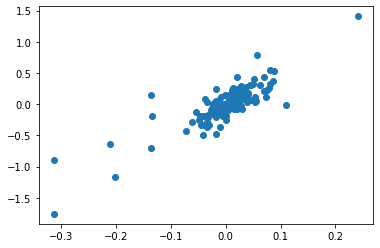

In [208]:
a = df['Movement']
b = df['MACD_Diff']


plt.scatter(b,a)


In [93]:


def MAC(MACDiff,MACD,Trigger,Movement,Vol):
    
    # rule 1 looking for buying point (MACDiff trending up - positive)
    if MACD <= 0:
        if MACD > Trigger :
            action = 'Buy MACD > Trigger'
        elif MACDiff > 0.01 and Movement > 0 and Vol > 0:
            action = 'Buy All positives'
        elif MACDiff > 0.01 and Movement > 0 and Vol < 0:
            action = 'Buy Vol Decline'
        elif MACDiff > 0.01 and Movement < 0 and Vol < 0:
            action = 'Buy Vol & Mvmt Decline'
        elif Movement > 0.01 and Vol > 0:
            action = 'Buy Mkt Reaction'
        elif MACDiff <= 0.01:
            action = 'Sell'             # default to sell (Negative MACD) to advise you if you have it in your portfolio
        else:
            action = 'Neutral - Buy'
            
    # rule 2 looking for selling point (positive MACD but trending downward) 
    elif MACD > 0:                          # reviewing positive histogram
        if MACD > Trigger:                  # still holding
            action = 'Hold MACD > Trigger'
        if MACD <= Trigger:
            action = 'Sell MACD < Trigger'
        elif MACDiff > 0.01 and Movement > 0 and Vol > 0:   # both showing positive sentiments
            action = 'Hold All Positives'
        elif MACDiff > 0.01 and Movement > 0 and Vol < 0:   # volume declines
            action = 'Hold Vol Decline'
        elif MACDiff > 0.01 and Movement < 0 and Vol < 0:   # volume and movement decline
            action = 'Hold Vol and Mvmt Decline'
        elif MACDiff < 0.01 and Movement < 0 and Vol < 0:   # all showing negative sentiments  but vol still low
            action = 'Sell Vol Still Low'
        elif MACDiff < 0.01 and Movement < 0 and Vol > 0:   # negative sentiments added by increse vol ppl panic
            action = 'Sell Vol High'
        else:
            action = ''
    
    # other rules
    else:
        action = 'Not tested'
        #print (MACD)
    return action
        
    
        

In [181]:
def MAC(MACD,Trigger,MACDiff,Movement,Vol):
    
    # rule 1 looking for buying point (MACDiff trending up - positive)
    
    if MACD >= Trigger:   # logic for MACD > Trigger
        if MACD <= 0:     # below x axis (negative MACD) 
            action = 'Buy Confirm'
        elif MACD > 0:    # above x axis (positive MACD)  
            if MACDiff > 0:
                action = 'Hold'
            else:
                action = 'Time to Sell'
    elif MACD < Trigger:  # logic for MACD < Trigger
        if MACD <=0:      # below x axis (negative MACD)
            if MACDiff > 0:
                action = 'Buy Accumulate'
            elif Movement > 0 and Vol > 0:
                action = 'Market Buying'
            else:
                action = 'Time to Sell'
        elif MACD > 0:    # above x axis (positive MACD)
            if MACDiff > 0:
                action = 'Hold'
            elif Movement < 0 and Vol > 0:
                action = 'Market Selling'
            else:
                action = 'Time to Sell'
    else:
        action='Noting'
            
    return action
        

In [182]:
df.columns

Index(['Close', 'Volume', 'Code', 'ShortAvg', 'LongAvg', 'MACD', 'Trigger',
       'Movement', '2DAvg', 'Max', 'Min', 'VolDiff', 'P/Max'],
      dtype='object')

In [186]:

df = data['WPL.AX'][['Close','Volume']]     # new one using Yfinance
df['Code'] = 'WPL.AX'


ma_day = [5, 10]


for ma in ma_day:
    column_name = f"Avg-{ma}days"
    df[column_name] = df['Close'].ewm(span=ma).mean()
    

df['Mov-3Days'] = df['Close'].diff(3)
df['MACD'] = df.iloc[:,3] - df.iloc[:,4]    # column 5 - columns 4 (Long - Short Avg)    
df['Trigger'] = df.MACD.rolling(window=3).mean()
df['MACD_Diff'] = df['MACD'].diff(1)
df['Vol_Diff'] = df['Volume'].diff(1)
df['Advice'] = df.apply(lambda x:MAC(x['MACD'],x['Trigger'],x['MACD_Diff'],x['Mov-3Days'],x['Vol_Diff']),axis=1)

#df['Pct'] = df['Close'].pct_change()   
#df['Max'] = df['Close']/df['Close'].max()
#df['Min'] = df['Close']/df['Close'].min()
#df['MACD-MAX'] = df['MACD'].max()
#df = df[['Close', 'Volume', 'Code', 'Avg-5days', 'Avg-10days', 'Avg-30days',
 #      'Pct', 'Max', 'Min', 'Movement',  'MACD-MAX'
  #     , 'Vol_Diff','MACD','Trigger','MACD_Diff']]
#df['Valuation'] = 44


df.tail(50)

,Close,Volume,Code,Avg-5days,Avg-10days,Mov-3Days,MACD,Trigger,MACD_Diff,Vol_Diff,Advice
Date,,,,,,,,,,,
2020-12-04,23.00,2249039,WPL.AX,22.72,22.44,0.80,0.28,0.26,0.02,"-1,120,809.00",Hold
2020-12-07,23.15,2538432,WPL.AX,22.86,22.57,0.73,0.29,0.28,0.02,"289,393.00",Hold
2020-12-08,23.11,3344625,WPL.AX,22.94,22.66,0.26,0.28,0.28,-0.02,"806,193.00",Time to Sell
2020-12-09,22.81,3001041,WPL.AX,22.90,22.69,-0.19,0.21,0.26,-0.07,"-343,584.00",Time to Sell
2020-12-10,22.73,2553231,WPL.AX,22.84,22.70,-0.42,0.14,0.21,-0.06,"-447,810.00",Time to Sell
2020-12-11,23.31,3689749,WPL.AX,23.00,22.81,0.20,0.19,0.18,0.04,"1,136,518.00",Hold
2020-12-14,23.19,2479065,WPL.AX,23.06,22.88,0.38,0.18,0.17,-0.01,"-1,210,684.00",Time to Sell
2020-12-15,22.70,3150952,WPL.AX,22.94,22.85,-0.03,0.10,0.16,-0.09,"671,887.00",Market Selling
2020-12-16,22.88,2575353,WPL.AX,22.92,22.85,-0.43,0.07,0.12,-0.03,"-575,599.00",Time to Sell


In [110]:
import math
math.ceil(0.12222)

1

In [146]:
df.iloc[:,1] = 'Test'

In [117]:
df['Volume'].diff(1)

,Close,Volume,Code,Avg-5days,Avg-10days,Avg-30days,Max,Min,Pct,MACD
Date,,,,,,,,,,
2020-07-01,21.60,Test,WPL.AX,21.60,21.60,21.60,27.40,16.80,nan,0.00
2020-07-02,21.77,Test,WPL.AX,21.70,21.69,21.69,27.40,16.80,0.01,-0.01
2020-07-03,21.65,Test,WPL.AX,21.68,21.68,21.67,27.40,16.80,-0.01,-0.00
2020-07-06,21.58,Test,WPL.AX,21.64,21.64,21.65,27.40,16.80,-0.00,0.01
2020-07-07,21.27,Test,WPL.AX,21.50,21.54,21.56,27.40,16.80,-0.01,0.04
...,...,...,...,...,...,...,...,...,...,...
2021-02-10,25.28,Test,WPL.AX,25.35,25.38,24.98,27.40,16.80,-0.00,0.04
2021-02-11,25.22,Test,WPL.AX,25.30,25.35,24.99,27.40,16.80,-0.00,0.05
2021-02-12,24.98,Test,WPL.AX,25.20,25.29,24.99,27.40,16.80,-0.01,0.09


<AxesSubplot:xlabel='Date'>

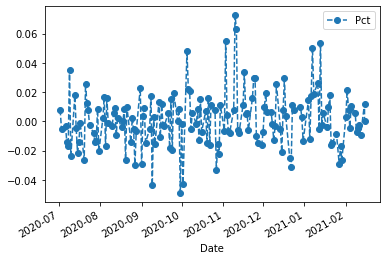

In [89]:
df['Pct'].plot(legend=True, linestyle='--', marker='o')


/Users/ronny/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Pct', ylabel='Density'>

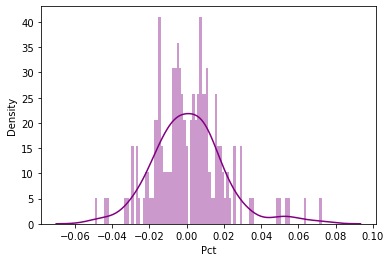

In [90]:
  
    import seaborn as sns
    sns.distplot(df['Pct'].dropna(), bins=100, color='purple')

In [48]:
 df.loc[:,'ShortAvg'] = df.Close.ewm(span=5).mean()        
    df.loc[:,'LongAvg'] = df.Close.ewm(span=14).mean()
    df['MACD'] = df['ShortAvg'] - df['LongAvg']
    df['Trigger'] = df.MACD.rolling(window=4).mean()
    df['Movement'] = df['Close'].diff(1)
    df['2DAvg'] = df.Movement.rolling(window=2).sum()
    df['Max'] = df['Close'].max()
    df['Min'] = df['Close'].min()
    df['VolDiff'] = df['Volume'].diff(1)
    df['P/Max'] = df['Close']/df['Max']

,Close,Volume,Code,10,MA for 10 days,MA for 20 days,MA for 50 days
Date,,,,,,,
2020-07-01,21.60,2177395,WPL.AX,nan,nan,nan,nan
2020-07-02,21.77,1954751,WPL.AX,nan,nan,nan,nan
2020-07-03,21.65,1823163,WPL.AX,nan,nan,nan,nan
2020-07-06,21.58,1557653,WPL.AX,nan,nan,nan,nan
2020-07-07,21.27,2661952,WPL.AX,nan,nan,nan,nan
...,...,...,...,...,...,...,...
2021-02-10,25.28,1676137,WPL.AX,25.14,25.14,25.89,24.26
2021-02-11,25.22,1252022,WPL.AX,25.15,25.15,25.82,24.31
2021-02-12,24.98,1253328,WPL.AX,25.20,25.20,25.74,24.36


Things you want to improve:

- Add LVR as numbers and workout daily interest rate etc
- Validation of your buy recommendations

In [39]:
from IPython.display import display


print("Enter Your Date YYYY-MM-DD ")
mydate = input()
mydate = pd.to_datetime(mydate)


print (mydate)

Enter Your Date YYYY-MM-DD 
2021-02-12
2021-02-12 00:00:00


In [41]:
mylist = ['^AORD','^DJI','WPL.AX','AGL.AX','IAG.AX','TWE.AX','LNK.AX','CSL.AX','ALL.AX','ORG.AX']
mycol = ['Date','Code','Close','MACD','Trigger','MACD_Diff','Movement','2DAvg','Min','Max','P/Max','Advice']
rec = code[mycol]
rec['Daily%'] = rec['Close'].pct_change()
rec = rec[['Date','Code','Close','MACD','Trigger','MACD_Diff','Movement','2DAvg','Min','Max','P/Max','Daily%','Advice']]


b = rec[(rec['Date']==mydate) & (rec['Code'].isin(mylist))]
a = rec[(rec['Date']==mydate) & rec['Advice'].str.contains('trigger') & (rec['P/Max'] < 0.91)]


#mystock = pd.read_csv(mycsv)
mystock = df
mystock = mystock.rename(columns={'ASX Code':'Code'})
mystock['Code']=mystock['Code'] + '.AX'
mycol = ['Date','Code','Security Name','Industry','LVR','Close','MACD','Trigger','2DAvg','Max','P/Max','Advice']
mybuy = pd.merge(a,mystock,on='Code')
mybuy = mybuy[mycol]

mybuy = mybuy.sort_values(['LVR','P/Max'],ascending=False)
#mybuy.style.set_properties(**{'text-align': 'left'})




######## Calculate Profit ###########

from pandas import DataFrame

myval = [
    # Bought Date, Sold Date, Code, Type, Unit, Price, Margin
   
    
    ['2020-10-15',mydate,'AGL.AX','Long Term',4447,13.55],
    ['2020-12-15',mydate,'AGL.AX','Short Term',775,12.885],
    ['2020-8-27',mydate,'IAG.AX','Long Term',6060,5.08],
    ['2020-12-04',mydate,'CSL.AX','Long Term',33,294.19], 
    ['2020-12-11',mydate,'CSL.AX','Long Term',68,292.025], 
    ['2020-12-21',mydate,'CSL.AX','Long Term',34,287.511], 
    ['2021-1-12' ,mydate,'CSL.AX','Short Term',54,274.11],     
    ['2020-8-26',mydate,'WPL.AX','Long Term',1275,19.98],
    ['2020-11-25',mydate,'WPL.AX','Long Term',427,23.36],
    ['2020-12-2',mydate,'WPL.AX','Long Term',224,22.24],
    ['2020-12-21',mydate,'TWE.AX','Long Term',607,9.38],
    ['2021-1-4',mydate,'LNK.AX','Long Term',1236,4.78]
    
     ]

tmp = DataFrame (myval,columns=['PurchaseDate','CurrentDate','Code','Position','Unit','Price'])

myprofit = pd.merge(tmp,b,on='Code',how='left')
mymargin = mystock[mystock['Code'].isin(mylist)]
myprofit = pd.merge(myprofit,mymargin,on='Code',how='left')
#myprofit = pd.merge(myprofit,df,on='Code',how='left')

myprofit = myprofit[['PurchaseDate','CurrentDate','Code','Position','Unit','Price','LVR','Close','Advice']]
myprofit['PurchaseDate']=pd.to_datetime(myprofit['PurchaseDate'])
myprofit['Profit'] = (myprofit['Close'] - myprofit['Price']) * myprofit['Unit']
myprofit['Profit%'] = myprofit['Profit']/(myprofit['Unit']*myprofit['Price']) * 100
myprofit['Loan'] = myprofit['Unit'] * myprofit['Price'] * myprofit['LVR']
myprofit['Margin'] = myprofit['Unit'] * myprofit['Price'] * (1 - myprofit['LVR'])
#myprofit['LoanInterest'] = myprofit['Loan'] * 4/100
myprofit['Days'] = myprofit['CurrentDate'] - myprofit['PurchaseDate']
myprofit['Days'] = myprofit['Days'].dt.days.astype('int16')
myprofit['Interest'] = myprofit['Loan'] * 3.75/100 / 365 * myprofit['Days']



display (b)
display (myprofit)
display (mybuy)
#display (mybuy.style.set_properties(**{'text-align': 'left'}))
#type(a)

,Date,Code,Close,MACD,Trigger,MACD_Diff,Movement,2DAvg,Min,Max,P/Max,Daily%,Advice
1768,2021-02-12,AGL.AX,11.05,-0.21,-0.23,-0.01,-0.25,-0.11,10.88,17.59,0.63,-0.02,MACD declines
2734,2021-02-12,ALL.AX,33.07,0.61,0.80,-0.15,-0.18,-0.49,24.18,34.59,0.96,-0.01,Buy - but momentum declines
15775,2021-02-12,CSL.AX,276.76,0.63,0.47,0.08,0.06,0.66,266.90,318.58,0.87,0.00,Buy - positive signal
25435,2021-02-12,IAG.AX,5.34,0.14,0.09,0.02,-0.01,0.05,4.38,5.83,0.92,-0.00,Buy - positive signal
30587,2021-02-12,LNK.AX,4.77,-0.03,-0.01,-0.01,-0.02,-0.09,3.73,5.64,0.85,-0.00,Sell
38315,2021-02-12,ORG.AX,4.36,-0.18,-0.20,0.00,-0.08,-0.08,4.00,6.02,0.72,-0.02,MACD flat with sell activity
52966,2021-02-12,TWE.AX,10.15,0.18,0.20,-0.03,-0.07,-0.19,7.96,12.85,0.79,-0.01,Buy - but momentum declines
60211,2021-02-12,WPL.AX,24.98,-0.12,-0.06,-0.06,-0.24,-0.30,16.80,27.40,0.91,-0.01,Sell


,PurchaseDate,CurrentDate,Code,Position,Unit,Price,LVR,Close,Advice,Profit,Profit%,Loan,Margin,Days,Interest
0,2020-10-15,2021-02-12,AGL.AX,Long Term,4447,13.55,0.75,11.05,MACD declines,"-11,117.50",-18.45,"45,192.64","15,064.21",120,557.17
1,2020-12-15,2021-02-12,AGL.AX,Short Term,775,12.88,0.75,11.05,MACD declines,"-1,422.12",-14.24,"7,489.41","2,496.47",59,45.40
2,2020-08-27,2021-02-12,IAG.AX,Long Term,6060,5.08,0.75,5.34,Buy - positive signal,"1,575.60",5.12,"23,088.60","7,696.20",169,400.89
3,2020-12-04,2021-02-12,CSL.AX,Long Term,33,294.19,0.75,276.76,Buy - positive signal,-575.19,-5.92,"7,281.20","2,427.07",70,52.36
4,2020-12-11,2021-02-12,CSL.AX,Long Term,68,292.02,0.75,276.76,Buy - positive signal,"-1,038.02",-5.23,"14,893.27","4,964.42",63,96.40
5,2020-12-21,2021-02-12,CSL.AX,Long Term,34,287.51,0.75,276.76,Buy - positive signal,-365.53,-3.74,"7,331.53","2,443.84",53,39.92
6,2021-01-12,2021-02-12,CSL.AX,Short Term,54,274.11,0.75,276.76,Buy - positive signal,143.10,0.97,"11,101.45","3,700.49",31,35.36
7,2020-08-26,2021-02-12,WPL.AX,Long Term,1275,19.98,0.75,24.98,Sell,"6,375.00",25.03,"19,105.88","6,368.62",170,333.70
8,2020-11-25,2021-02-12,WPL.AX,Long Term,427,23.36,0.75,24.98,Sell,691.74,6.93,"7,481.04","2,493.68",79,60.72
9,2020-12-02,2021-02-12,WPL.AX,Long Term,224,22.24,0.75,24.98,Sell,613.76,12.32,"3,736.32","1,245.44",72,27.64


,Date,Code,Security Name,Industry,LVR,Close,MACD,Trigger,2DAvg,Max,P/Max,Advice
1,2021-02-12,GMG.AX,Goodman Group,Real Estate,0.70,17.96,-0.06,-0.11,0.39,19.97,0.90,Buy - positive trigger
0,2021-02-12,DXS.AX,Dexus Property Group,Real Estate,0.70,8.72,-0.12,-0.15,0.06,9.90,0.88,Buy - positive trigger
3,2021-02-12,NCM.AX,Newcrest Mining Limited,Materials,0.70,25.96,-0.00,-0.21,0.76,36.80,0.71,Buy - positive trigger
5,2021-02-12,SGM.AX,Sims Group Limited,Materials,0.60,12.55,-0.19,-0.19,-0.17,14.27,0.88,Buy - weak trigger
4,2021-02-12,NST.AX,Northern Star Resources Limited,Materials,0.60,12.06,-0.27,-0.33,-0.03,16.84,0.72,Buy - weak trigger
2,2021-02-12,KGN.AX,Kogan.com Limited,Retailing,0.45,16.76,-0.80,-0.81,-0.50,25.10,0.67,Buy - weak trigger


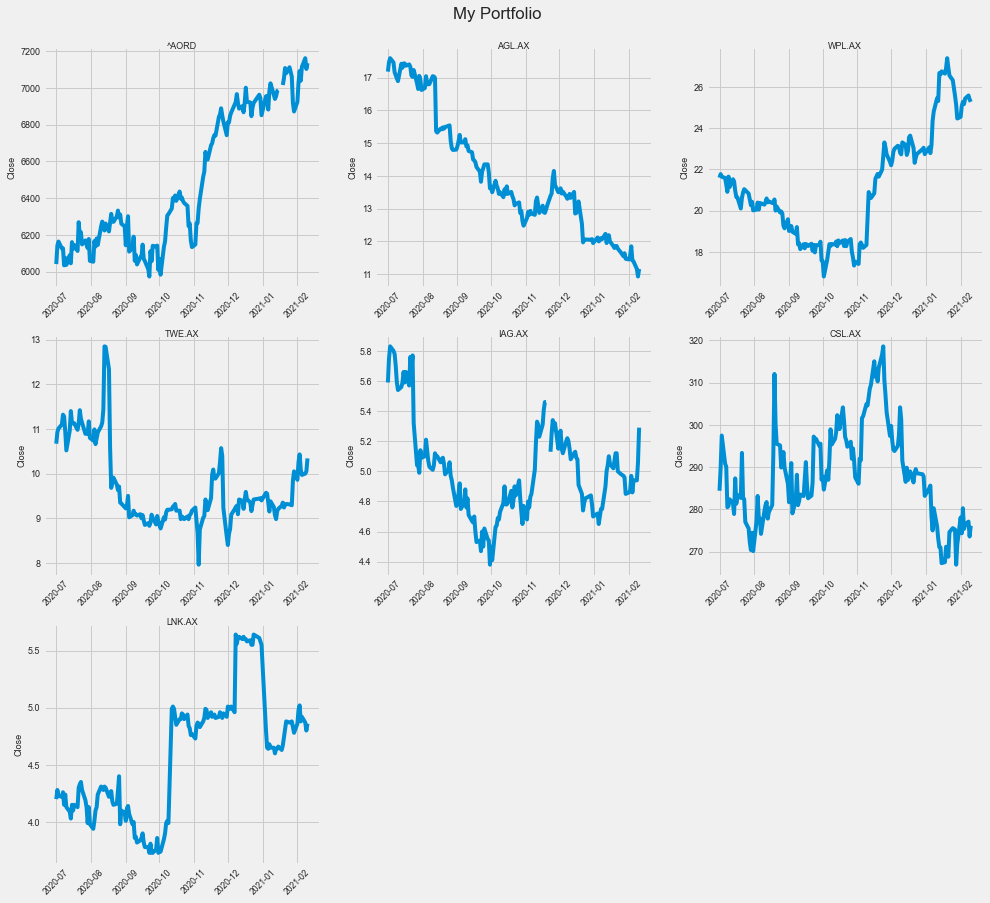

In [151]:
# Let's see a historical view of the closing price
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use("ggplot")

mylist = ['^AORD','AGL.AX','WPL.AX','TWE.AX','IAG.AX','CSL.AX','LNK.AX']
plt.figure(figsize=(15, 14))
plt.suptitle('My Portfolio',y=0.92)   # y = 1 is at the top of the figure so reduce it to make it lower
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(mylist, 1):
    plt.subplot(3, 3, i)
    #code['Close'].plot()
    tmpStock = code[code['Code']==company]
    x = tmpStock['Date']
    y = tmpStock['Close']
    plt.plot(x,y)
    plt.xticks(rotation=45,fontsize=8.5)
    plt.yticks(fontsize=9)
    plt.ylabel('Close',fontsize=9)
    plt.xlabel(None)
    plt.title(company,fontsize=9,y=0.97)

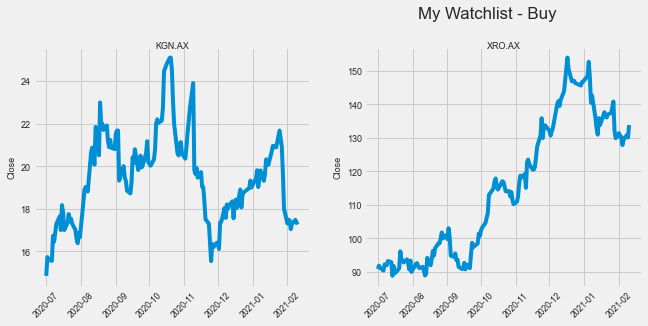

In [179]:
# Let's see a historical view of the closing price
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#plt.style.use("ggplot")

mylist = ['KGN.AX','XRO.AX']
plt.figure(figsize=(15, 14))
plt.suptitle('My Watchlist - Buy',y=0.92)   # y = 1 is at the top of the figure so reduce it to make it lower
#plt.subplots_adjust(top=1.25, bottom=1.2)

for i, company in enumerate(mylist, 1):
    plt.subplot(3, 3, i)
    #code['Close'].plot()
    tmpStock = code[code['Code']==company]
    x = tmpStock['Date']
    y = tmpStock['Close']
    plt.plot(x,y)
    plt.xticks(rotation=45,fontsize=8.5)
    plt.yticks(fontsize=9)
    plt.ylabel('Close',fontsize=9)
    plt.xlabel(None)
    plt.title(company,fontsize=9,y=0.97)

Enter the code you want to check
AGL.AX


Text(0.5, 0, 'Long vs Short Avg')

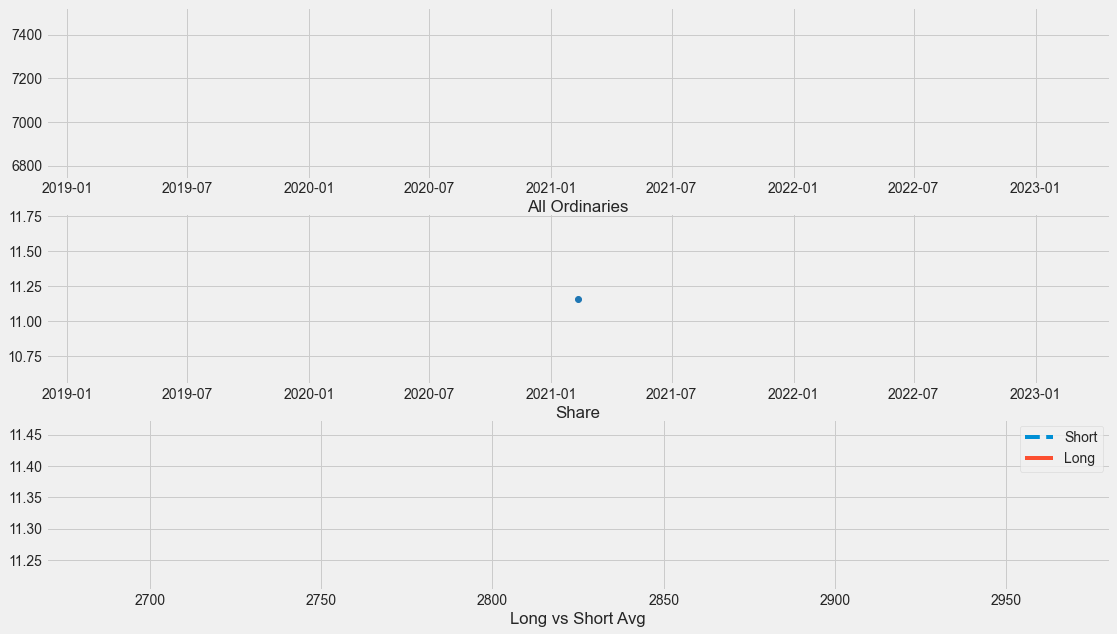

In [152]:
import matplotlib.pyplot as plt

print("Enter the code you want to check")
x = input()

plt.subplots(figsize=(17,10))

code = mytbl[(mytbl['Code']==x) & (mytbl['Date']>=mydate)]
code.dropna(subset=['Close'],inplace=True)
index = mytbl[(mytbl['Code']=='^AORD') & (mytbl['Date']>=mydate)]
index.dropna(subset=['Close'],inplace=True)


plt.subplot(311)
a = index['Date']
b = index['Close']
plt.plot(a,b,color='tab:orange',linestyle='--')
plt.xlabel('All Ordinaries')

plt.subplot(312)
a = code['Date']
b = code['Close']
plt.plot(a,b,color='tab:blue', marker='o')
plt.xlabel('Share')

plt.subplot(313)
short = code['ShortAvg']
long = code['LongAvg']

plt.plot(short, label ='Short',linestyle='--')
plt.plot(long, label = 'Long')
plt.legend()
plt.xlabel('Long vs Short Avg')

In [64]:
code[code['Code']=='WPL.AX']


,Date,Code,Close,Movement,Volume,ShortAvg,LongAvg,MACD,Trigger,Max,Min,2DAvg,VolDiff,P/Max


In [19]:
code

,Date,Code,Close,Movement,Volume,ShortAvg,LongAvg,MACD,Trigger,Max,Min,2DAvg,VolDiff,P/Max
2721,2020-07-01,AGL.AX,17.18,nan,"2,097,177.00",17.18,17.18,0.00,nan,17.59,10.93,nan,nan,0.98
2722,2020-07-02,AGL.AX,17.47,0.29,"1,715,790.00",17.35,17.34,0.02,nan,17.59,10.93,nan,"-381,387.00",0.99
2723,2020-07-03,AGL.AX,17.59,0.12,"1,187,010.00",17.47,17.43,0.03,nan,17.59,10.93,0.41,"-528,780.00",1.00
2724,2020-07-06,AGL.AX,17.46,-0.13,"1,503,119.00",17.46,17.44,0.02,0.02,17.59,10.93,-0.01,"316,109.00",0.99
2725,2020-07-07,AGL.AX,17.16,-0.30,"2,698,522.00",17.35,17.37,-0.02,0.01,17.59,10.93,-0.43,"1,195,403.00",0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2021-02-03,AGL.AX,11.85,0.28,"2,902,164.00",11.65,11.73,-0.08,-0.16,17.59,10.93,0.40,"601,063.00",0.67
2876,2021-02-04,AGL.AX,11.42,-0.43,"7,440,132.00",11.57,11.69,-0.12,-0.14,17.59,10.93,-0.15,"4,537,968.00",0.65
2877,2021-02-05,AGL.AX,11.39,-0.03,"2,932,016.00",11.51,11.65,-0.14,-0.12,17.59,10.93,-0.46,"-4,508,116.00",0.65
2878,2021-02-08,AGL.AX,11.16,-0.23,"2,665,791.00",11.39,11.58,-0.19,-0.13,17.59,10.93,-0.26,"-266,225.00",0.63


In [53]:
mylist = df['Code'].drop_duplicates().to_list()

code[(code['Code'].isin(mylist)) & (code['Date']=='2021-02-01')]



,Date,Code,Close,Movement,Volume,ShortAvg,LongAvg,MACD,Trigger,Max,Min,2DAvg,VolDiff,P/Max
61913,2021-02-01,WPL.AX,24.55,0.08,"3,095,316.00",25.02,25.46,-0.44,-0.14,27.40,16.80,-0.59,"-487,903.00",0.90


In [59]:
code['Code'].value_counts()

WPL.AX    156
Name: Code, dtype: int64

In [6]:
import numpy as np


#mydate = datetime.date.today().strftime("%Y-%m-%d")
#mydate = datetime.date.today() + datetime.timedelta(days=0) #change time delta accordingly, default = 0 or now
# the format of this input : Start, End, Code, Type, Unit, Price
print("Enter Your Date YYYY-MM-DD ")
mydate = input()
mydate = pd.to_datetime(mydate)
# type --> b = buy , s = sell , w = watchlist
myval = [
    # Bought Date, Sold Date, Code, Type, Unit, Price, Margin
   
    
    ['2020-10-15',mydate,'AGL.AX','Long Term',4447,13.55],
    ['2020-12-15',mydate,'AGL.AX','Short Term',775,12.885],
    ['2020-8-27',mydate,'IAG.AX','Long Term',6060,5.08],
    ['2020-12-04',mydate,'CSL.AX','Long Term',33,294.19], 
    ['2020-12-11',mydate,'CSL.AX','Long Term',68,292.025], 
    ['2020-12-21',mydate,'CSL.AX','Long Term',34,287.511], 
    ['2021-1-12' ,mydate,'CSL.AX','Short Term',54,274.11],     
    ['2020-8-26',mydate,'WPL.AX','Long Term',1275,19.98],
    ['2020-11-25',mydate,'WPL.AX','Long Term',427,23.36],
    ['2020-12-2',mydate,'WPL.AX','Long Term',224,22.24],
    ['2020-12-21',mydate,'TWE.AX','Long Term',607,9.38],
    ['2021-1-4',mydate,'LNK.AX','Long Term',1236,4.78]
    
     ]

# create two tables (manual input vs table for ALLORD)
myinput = pd.DataFrame(myval,columns=['Date','Date_to','Code','Type','Unit','Price'])
myinput['Date']= myinput['Date'].astype('datetime64[ns]')                  # change from objec to the date type
allord = code[code['Code']=='^AORD'][['Date','Close']]



# merge tables to create a consolidated with share vs ordinary

benchmark = pd.merge(myinput,allord,on='Date',how='inner')
#benchmark['']

# loop all the description and create dataframe 
for i in range(len(benchmark['Date'])):
        StartDate = benchmark.loc[i,'Date']
        EndDate = benchmark.loc[i,'Date_to']
        Code = benchmark.loc[i,'Code']
        Unit = benchmark.loc[i,'Unit']
        Price = benchmark.loc[i,'Price']
        Index = benchmark.loc[i,'Close']
        Type = benchmark.loc[i,'Type']
        
        dateseries = pd.date_range(StartDate,EndDate)
        mypurchasedate = np.repeat(StartDate,len(dateseries))
        myunit = np.repeat(Unit,len(dateseries))
        myprice = np.repeat(Price,len(dateseries))
        mycode = Code
        
        if i ==0 : # create the main dataframe the first time
            df1 = pd.DataFrame ({'Date':dateseries, 'Bought_Date':StartDate,'Type':Type,'Code':mycode,'Unit':myunit,'Price':myprice,'Index':Index})
        else:      # create tmp and append to main dataframe
            tmp = pd.DataFrame ({'Date':dateseries, 'Bought_Date':StartDate,'Type':Type,'Code':mycode,'Unit':myunit,'Price':myprice,'Index':Index})
            df1 = df1.append(tmp)
            

            
# create final profit table         

#mydate = datetime.date.today() + datetime.timedelta(days=-1)    #change time delta accordingly, default = 0 or now
mydate = mydate.strftime("%Y-%m-%d")
myprofit =  pd.merge(df1,code,on=['Date','Code'],how='inner')[['Date','Bought_Date','Type','Code','Unit_x','Price','Close','Index']]
myprofit =  pd.merge(myprofit,allord,on='Date',how='inner')
myprofit = myprofit.rename(columns={'Unit_x':'Unit','Close_x':'Close','Close_y':'Index_Close'})
myprofit = myprofit.sort_values(by=['Type'])
myprofit['Index_Unit'] = (myprofit['Unit'] * myprofit['Price'])/myprofit['Index']
myprofit['MyProfit'] = (myprofit['Close'] - myprofit['Price']) * myprofit['Unit']
myprofit['Benchmark'] = (myprofit['Index_Close'] - myprofit['Index']) * myprofit['Index_Unit']
#myprofit['Profit_Impact'] = myprofit['MyProfit'] - myprofit['Benchmark']
myprofit['Profit%'] = (myprofit['Close']-myprofit['Price'])/myprofit['Price']
myprofit['Index%'] = (myprofit['Index_Close']-myprofit['Index'])/myprofit['Index_Close']
myprofit['Diff%'] = myprofit['Profit%'] - myprofit['Index%']  
myprofit['TotCost'] = myprofit['Unit'] * myprofit['Price']  
#myprofit.style.format({'Profit%':"{:.2%}"})




mycolumns = ['Type','Code','Date','Bought_Date','Unit','Price','TotCost','Close','MyProfit','Benchmark','Profit%','Index%','Diff%']
myprofit = myprofit[mycolumns]

myprofit[myprofit['Date'] == mydate]
mydf = myprofit[myprofit['Date']==mydate].sort_values(by=['Type','Code','Bought_Date'])
#myprofit.style.format({'Profit%':"{:.2%}",'Index%':"{:.2%}"})
#myprofit[myprofit['Date'] == mydate]

final = mydf.groupby('Code').sum()[['Unit','TotCost']]
final['AvgCost'] = final['TotCost']/final['Unit']

print ('########## Your Average Costs ############')
print (final)


print ('########### Benchmark against all ordinaries ##############')

mylvr = mystock[['Code','LVR']]

mydf = pd.merge(mydf,mylvr,on='Code',how='left')
#mydf['MarginUsed'] = mydf['LVR'] * mydf['TotCost']
mydf


Enter Your Date YYYY-MM-DD 
2021-02-02


NameError: name 'df1' is not defined

In [5]:
print ('### Overall Profit ###')
overall = mydf.groupby('Type').sum()[['Unit','MyProfit']]

print (overall)

mydf.groupby('Code').sum()[['Unit','MyProfit']]

### Overall Profit ###


NameError: name 'mydf' is not defined